# Hybrid model

In [228]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sqlite3

In [229]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
df = df[['Close']]
df.head(5)

,Close
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011


In [230]:
train = df[:320]
test = df[320:]

In [231]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train.values, order=(5,1,0))
arima_fit = model.fit()
y = arima_fit.predict(start=0, end=320)

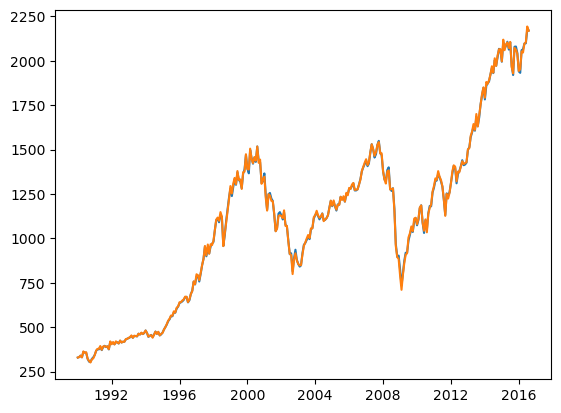

In [232]:
plt.plot(train.index, train['Close'],label='Original')
plt.plot(train.index, y[1:], label='Predicted')

In [233]:
temp = pd.DataFrame({'Close': y[1:]})
temp.head(5)

,Close
0,329.107761
1,331.958552
2,340.180253
3,330.262988
4,363.770680


In [234]:
temp['Close_1'] = temp['Close']
temp['Close_2'] = temp['Close'].shift(-1)
temp['Close_3'] = temp['Close'].shift(-2)
temp['Close'] = temp['Close'].shift(-3)
temp.dropna(inplace=True)
print(len(temp))
temp.head(5)

317


,Close,Close_1,Close_2,Close_3
0,330.262988,329.107761,331.958552,340.180253
1,363.770680,331.958552,340.180253,330.262988
2,356.127477,340.180253,330.262988,363.770680
3,359.328793,330.262988,363.770680,356.127477
4,322.164337,363.770680,356.127477,359.328793


In [235]:
X = temp[['Close_1','Close_2','Close_3']]
y = temp['Close']

In [236]:
X = X.to_numpy()
y = y.to_numpy()

In [237]:
X_train = X
y_train = y

In [238]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
y_train = y_train.float()

# Designing ANN Model

In [239]:
class Model(nn.Module):
    def __init__(self, in_features=3, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 20)
        self.out = nn.Linear(20,out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x
    
    def predict(self, test):
        with torch.no_grad():
            y_eval = self.forward(test)
            return y_eval



In [240]:
torch.manual_seed(41)
ANN = Model()
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(ANN.parameters(), lr=0.01)

In [241]:
epochs = 100
losses = []
for i in range(epochs):
    y_pred = ANN.forward(X_train)
    loss = criterion(y_pred, y_train.unsqueeze(1))
    losses.append(loss.detach().numpy())
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and loss: 1274004.625
Epoch: 10 and loss: 34033.5078125
Epoch: 20 and loss: 47751.84375
Epoch: 30 and loss: 17130.1484375
Epoch: 40 and loss: 3317.111083984375
Epoch: 50 and loss: 5590.869140625
Epoch: 60 and loss: 3231.760986328125
Epoch: 70 and loss: 3453.69873046875
Epoch: 80 and loss: 3108.443115234375
Epoch: 90 and loss: 3113.38916015625


In [242]:
y_eval = ANN.predict(X_train)

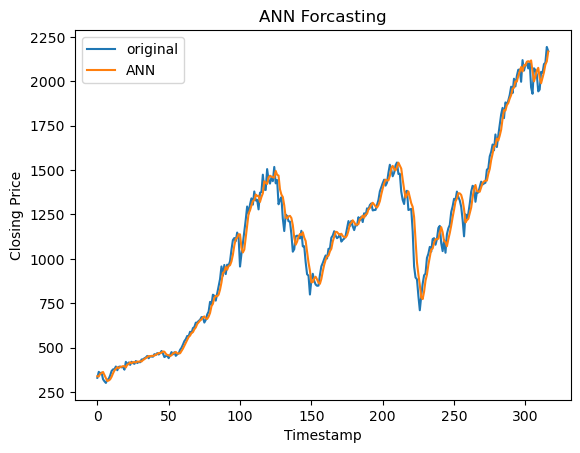

In [243]:
plt.plot(temp.index,temp['Close'],label="original")
plt.plot(temp.index,y_eval,label='ANN')
plt.xlabel('Timestamp')
plt.ylabel('Closing Price')
plt.title('ANN Forcasting')
plt.legend()
plt.show()

In [244]:
from tqdm import tqdm
train_ar_m = df['Close'][:320].values
test_ar_m = df['Close'][320:].values
history = [x for x in train_ar_m]
print(type(history))
predictions_m = list()
for t in tqdm(range(len(test_ar_m))):
    model = ARIMA(history, order=(5,1,0))
    arima_fit = model.fit()
    output = arima_fit.forecast()
    yhat = output[0]
    predictions_m.append(yhat)
    obs = test_ar_m[t]
    history.append(obs)
    history.pop(0)
print('Monthly Basis Forecasting Perfomance')

<class 'list'>


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:27<00:00,  3.33it/s]

Monthly Basis Forecasting Perfomance


In [181]:
len(predictions_m)

93

In [182]:
from tqdm import tqdm
for t in tqdm(range(36)):
    model = ARIMA(history, order=(5,1,0))
    arima_fit = model.fit()
    output = arima_fit.forecast()
    yhat = output[0]
    predictions_m.append(yhat)
    history.append(yhat)
    history.pop(0)
print('Monthly Basis Forecasting Perfomance')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.68it/s]

Monthly Basis Forecasting Perfomance


In [245]:
len(predictions_m)

93

In [246]:
temp = pd.DataFrame({'Close': predictions_m})
temp

,Close
0,2169.180753
1,2178.658387
2,2129.537610
3,2211.159488
4,2231.567807
...,...
88,4678.504039
89,4809.082350
90,5105.833728
91,5296.398211


In [247]:
temp['Close_1'] = temp['Close']
temp['Close_2'] = temp['Close'].shift(-1)
temp['Close_3'] = temp['Close'].shift(-2)
temp.dropna(inplace=True)
print(len(temp))
temp.head(5)

91


,Close,Close_1,Close_2,Close_3
0,2169.180753,2169.180753,2178.658387,2129.537610
1,2178.658387,2178.658387,2129.537610,2211.159488
2,2129.537610,2129.537610,2211.159488,2231.567807
3,2211.159488,2211.159488,2231.567807,2280.599392
4,2231.567807,2231.567807,2280.599392,2368.014637


In [248]:
X = temp[['Close_1','Close_2','Close_3']]
X = X.to_numpy()
test = X
test = torch.FloatTensor(test)

In [249]:
y_eval = ANN.predict(test)

In [250]:
final = []
for i in y_eval:
    final.append(float(i))

In [251]:
len(final)

91

In [192]:
x = []
for i in range(127):
    x.append(i)

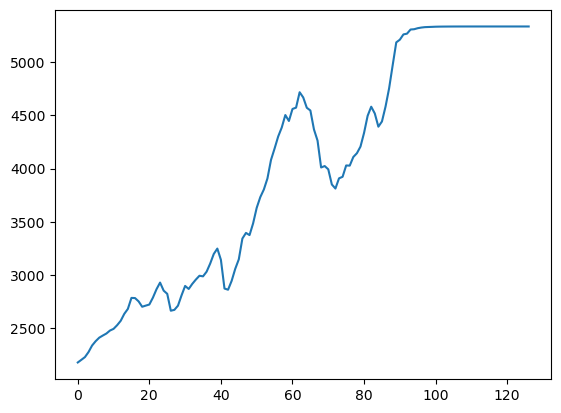

In [193]:
plt.plot(x,final)

In [204]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

start_date = datetime(2016, 9, 1)
end_date = start_date + relativedelta(months=+129)
monthly_dates = [start_date + relativedelta(months=+i) for i in range(0, 129)]
dates = []
for date in monthly_dates:
    dates.append(date.strftime('%Y-%m-%d'))
print(len(dates))
dates[:5]

129


['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01']

In [216]:
dates = dates[:127]

In [217]:
result = pd.DataFrame({'Timestamp':dates,"Predicted":final})
result.head(5)

,Timestamp,Predicted
0,2016-09-01,2176.555176
1,2016-10-01,2201.426270
2,2016-11-01,2227.097168
3,2016-12-01,2274.302246
4,2017-01-01,2335.999023


In [218]:
result['Timestamp'] = pd.to_datetime(result['Timestamp'])

In [219]:
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
result.to_sql('Hybrid_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [252]:
actual = df['Close'][320:320+91]
actual_d = df.index[320:320+91]

In [253]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(actual, final)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(actual, final)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(actual, final)
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(actual, final)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 10192.530
Symmetric Mean Absolute Percentage Error: 2.285
Mean Absolute Percenatage Error:2.314
R2-Score:0.985
